# Import Library

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import train_test_split
from pandas.tseries.offsets import BDay

# Step 1. Data Preparation

We are using Apple Inc as an example to test the performance of GPR model.

In [2]:
# Load the dataset
data = pd.read_csv('../stock-historical-data-analysis/appl.csv')

# Keep the original date for plotting
data['OriginalDate'] = pd.to_datetime(data['Date'])

# Convert Date to numerical feature
data['Date'] = (data['OriginalDate'] - data['OriginalDate'].min()).dt.days

In [3]:
data

,Date,Open,Close,Highest,Lowest,OriginalDate
0,0,18.967500,18.944286,18.999286,18.787500,2014-03-07
1,3,18.870000,18.961429,19.047500,18.869253,2014-03-10
2,4,19.123214,19.146072,19.240714,19.021072,2014-03-11
3,5,19.090000,19.164643,19.191071,19.000000,2014-03-12
4,6,19.193928,18.951786,19.273571,18.898571,2014-03-13
...,...,...,...,...,...,...
2513,3647,179.550000,179.660000,180.530000,177.380000,2024-03-01
2514,3650,176.150000,175.100000,176.900000,173.790000,2024-03-04
2515,3651,170.760000,170.120000,172.040000,169.620000,2024-03-05
2516,3652,171.060000,169.120000,171.240000,168.680000,2024-03-06


# Step 2. Model Training

In [4]:
# Splitting the dataset into training and testing sets
X = data[['Date', 'Open', 'Highest', 'Lowest']]
y = data['Close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a kernel with adjusted hyperparameters, increasing the upper bound for constant_value
kernel = C(1.0, (1e-3, 1e4)) * RBF(10, (1e-2, 1e2))

# Instantiate a Gaussian Process model with the adjusted kernel
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# Fit to data
gp.fit(X_train, y_train)

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=10),
                         n_restarts_optimizer=10)

# Step 3. Model Evaluation

In [5]:
from sklearn.metrics import mean_squared_error

# Make the prediction on the test set
y_pred, sigma = gp.predict(X_test, return_std=True)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 11.1416664906803


In [6]:
# Example: Predicting a new data point
new_data = [[50, 100, 105, 95]] # Format: [Date, Open, Highest, Lowest]
prediction, sigma = gp.predict(new_data, return_std=True)
print(f"Predicted Close: {prediction[0]}, Uncertainty: {sigma[0]}")


Predicted Close: -3.888452889844847e-38, Uncertainty: 55.64973376836748


/Users/dexinyang/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted with feature names
  warnings.warn(


# Step 4. Check The Accurate Rate of Result

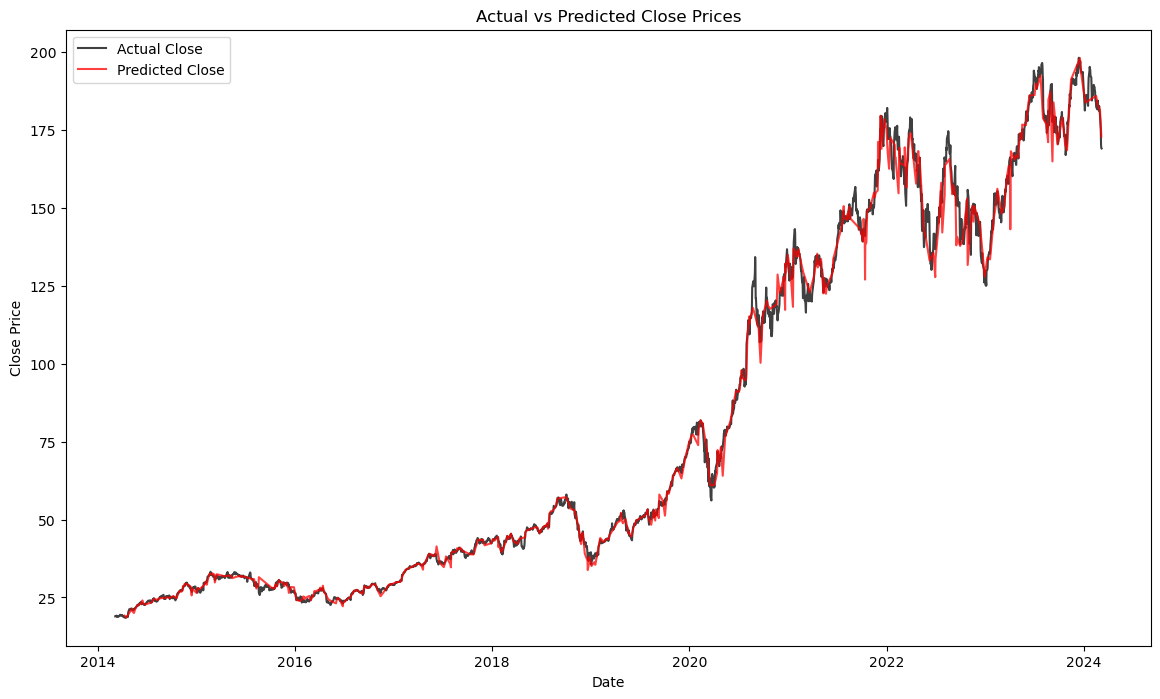

In [7]:
# Sort X_test by Date to ensure the lines are drawn correctly
X_test_sorted = X_test.sort_values(by='Date')
predicted_dates_sorted = X_test_sorted['Date'].apply(lambda x: data['OriginalDate'].min() + pd.Timedelta(days=x))

# Get the corresponding y_pred and sigma values for the sorted X_test
y_pred_sorted = gp.predict(X_test_sorted, return_std=False)
# sigma_sorted = gp.predict(X_test_sorted, return_std=True)[1]

# Plot actual vs predicted values as lines
plt.figure(figsize=(14, 8))

# Actual data
plt.plot(data['OriginalDate'], y, 'k-', label='Actual Close', alpha=0.75)

# Predicted data
plt.plot(predicted_dates_sorted, y_pred_sorted, 'r-', label='Predicted Close', alpha=0.75)

# # Plotting 95% confidence intervals
# lower_bound = y_pred_sorted - 1.96 * sigma_sorted
# upper_bound = y_pred_sorted + 1.96 * sigma_sorted

# plt.fill_between(predicted_dates_sorted, lower_bound, upper_bound, color='r', alpha=0.2, label='95% Confidence Interval')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Prices')
plt.legend()
plt.show()


# Step 5. Make Predictions for Next 7 Days

In [8]:
# Last available values from the dataset
last_values = data.iloc[-1][['Open', 'Highest', 'Lowest']].values

# Dates for the next week (business days only)
# Adjust 'last_date' as per your last available 'OriginalDate'
last_date = pd.to_datetime("2024-03-07")
next_week_dates = [last_date + pd.DateOffset(days=x) for x in range(1, 6) if (last_date + pd.DateOffset(days=x)).weekday() < 7]

# Prepare the features for the next week
next_week_features = []
for date in next_week_dates:
    days_since_start = (date - data['OriginalDate'].min()).days
    next_week_features.append([days_since_start] + list(last_values))

next_week_features = pd.DataFrame(next_week_features, columns=['Date', 'Open', 'Highest', 'Lowest'])

In [9]:
# Predict the Close prices for the next week
predicted_close_prices, sigma = gp.predict(next_week_features, return_std=True)

# Display the predictions with dates
for date, prediction, uncertainty in zip(next_week_dates, predicted_close_prices, sigma):
    print(f"Date: {date.date()}, Predicted Close: {prediction:.2f}, Uncertainty: ±{uncertainty:.2f}")


Date: 2024-03-08, Predicted Close: 167.01, Uncertainty: ±5.44
Date: 2024-03-09, Predicted Close: 163.47, Uncertainty: ±10.81
Date: 2024-03-10, Predicted Close: 158.46, Uncertainty: ±16.05
Date: 2024-03-11, Predicted Close: 152.13, Uncertainty: ±21.07
Date: 2024-03-12, Predicted Close: 144.62, Uncertainty: ±25.81


# Step 6. Plot The Prediction for Next 7 Days

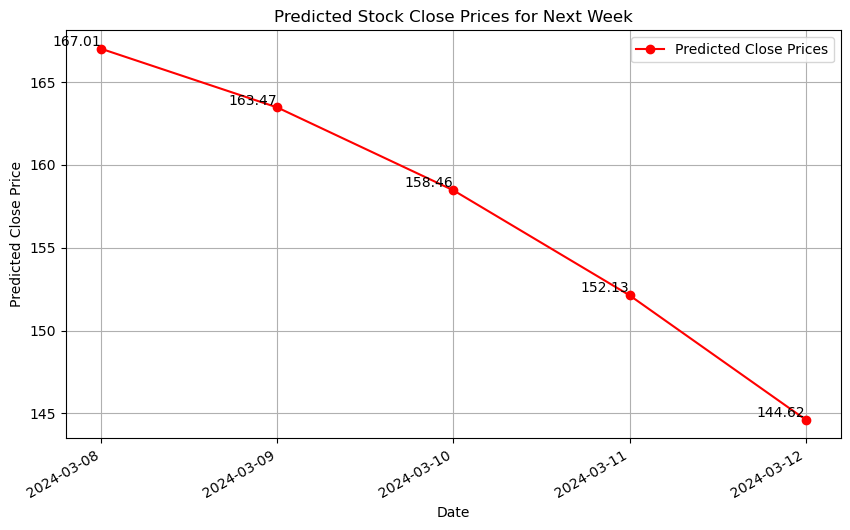

In [10]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(10, 6))

# Plot the predicted close prices
plt.plot(next_week_dates, predicted_close_prices, 'ro-', label='Predicted Close Prices')

# Annotate each point with its value
for date, value in zip(next_week_dates, predicted_close_prices):
    plt.text(date, value, f'{value:.2f}', color='black', ha='right', va='bottom')

# Formatting the date display
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gcf().autofmt_xdate()

plt.title('Predicted Stock Close Prices for Next Week')
plt.xlabel('Date')
plt.ylabel('Predicted Close Price')
plt.legend()
plt.grid(True)
plt.show()

# For first section, I just use the GRP model for a simple prediction. 
# For next section, I will add some additional factors in the model such as GDP growth, inflation, national election, epidemic, etc. We will see how they impact the prediction result.

In [15]:
# Load the datasets
stock_data = pd.read_csv('../stock-historical-data-analysis/appl.csv')
inflation_data = pd.read_csv('../inflation-rate-analysis/inflation_data.csv')

# Convert the 'Date' columns to datetime format in both datasets
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
inflation_data['Date'] = pd.to_datetime(inflation_data['Date'])

# Extract the year from the 'Date' column and create a new 'Year' column in both datasets
stock_data['Year'] = stock_data['Date'].dt.year
inflation_data['Year'] = inflation_data['Date'].dt.year

# Since inflation data might be yearly, ensure there are no duplicates for the same year
inflation_data = inflation_data.drop_duplicates(subset='Year', keep='first')

merged_data = pd.merge(stock_data, inflation_data[['Year', 'Inflation_Rate']], on='Year', how='left')


In [24]:
merged_data

,Date,Open,Close,Highest,Lowest,Year,Inflation_Rate,DateNum
0,2014-03-07,18.967500,18.944286,18.999286,18.787500,2014,NaN,0
1,2014-03-10,18.870000,18.961429,19.047500,18.869253,2014,NaN,3
2,2014-03-11,19.123214,19.146072,19.240714,19.021072,2014,NaN,4
3,2014-03-12,19.090000,19.164643,19.191071,19.000000,2014,NaN,5
4,2014-03-13,19.193928,18.951786,19.273571,18.898571,2014,NaN,6
...,...,...,...,...,...,...,...,...
2513,2024-03-01,179.550000,179.660000,180.530000,177.380000,2024,NaN,3647
2514,2024-03-04,176.150000,175.100000,176.900000,173.790000,2024,NaN,3650
2515,2024-03-05,170.760000,170.120000,172.040000,169.620000,2024,NaN,3651
2516,2024-03-06,171.060000,169.120000,171.240000,168.680000,2024,NaN,3652


# Training the Gaussian Process Regression Model

In [27]:

merged_data['DateNum'] = (merged_data['Date'] - merged_data['Date'].min()).dt.days  # Numerical date feature

# Fill missing values in 'Inflation_Rate' with forward fill method
merged_data['Inflation_Rate'] = merged_data['Inflation_Rate'].fillna(method='ffill')
merged_data['Inflation_Rate'] = merged_data['Inflation_Rate'].fillna(method='bfill')

# Prepare features and target variable
X = merged_data[['DateNum', 'Open', 'Highest', 'Lowest', 'Inflation_Rate']].copy()
y = merged_data['Close'].copy()

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a kernel with hyperparameters
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))

# Instantiate and fit the Gaussian Process model
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gp.fit(X_train, y_train)


/var/folders/f9/s_p2lp2s61v9bz87s04_kj540000gn/T/ipykernel_6870/2742396170.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data['Inflation_Rate'] = merged_data['Inflation_Rate'].fillna(method='ffill')
/var/folders/f9/s_p2lp2s61v9bz87s04_kj540000gn/T/ipykernel_6870/2742396170.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data['Inflation_Rate'] = merged_data['Inflation_Rate'].fillna(method='bfill')
/Users/dexinyang/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=10),
                         n_restarts_optimizer=10)

# Model Evaluation

In [28]:
# Make predictions on the test set
y_pred, sigma = gp.predict(X_test, return_std=True)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 15.582585241143438


In [30]:
# Predictions for the next 7 days
last_known_date = merged_data['Date'].max()
date_range_next_7_days = [last_known_date + pd.Timedelta(days=i) for i in range(1, 8)]
days_since_start_next_7_days = [(date - merged_data['Date'].min()).days for date in date_range_next_7_days]

last_known_values = merged_data.iloc[-1][['Open', 'Highest', 'Lowest', 'Inflation_Rate']]
X_next_7_days = pd.DataFrame({
    'DateNum': days_since_start_next_7_days,
    'Open': last_known_values['Open'],
    'Highest': last_known_values['Highest'],
    'Lowest': last_known_values['Lowest'],
    'Inflation_Rate': last_known_values['Inflation_Rate']
})

In [31]:
y_pred_next_7_days, sigma_next_7_days = gp.predict(X_next_7_days, return_std=True)

# Display predictions
for date, prediction, uncertainty in zip(date_range_next_7_days, y_pred_next_7_days, sigma_next_7_days):
    print(f"Date: {date.date()}, Predicted Close: {prediction:.2f}, Uncertainty: ±{uncertainty:.2f}")


Date: 2024-03-08, Predicted Close: 166.63, Uncertainty: ±3.44
Date: 2024-03-09, Predicted Close: 162.35, Uncertainty: ±6.83
Date: 2024-03-10, Predicted Close: 156.29, Uncertainty: ±10.11
Date: 2024-03-11, Predicted Close: 148.66, Uncertainty: ±13.21
Date: 2024-03-12, Predicted Close: 139.71, Uncertainty: ±16.10
Date: 2024-03-13, Predicted Close: 129.71, Uncertainty: ±18.74
Date: 2024-03-14, Predicted Close: 118.97, Uncertainty: ±21.11


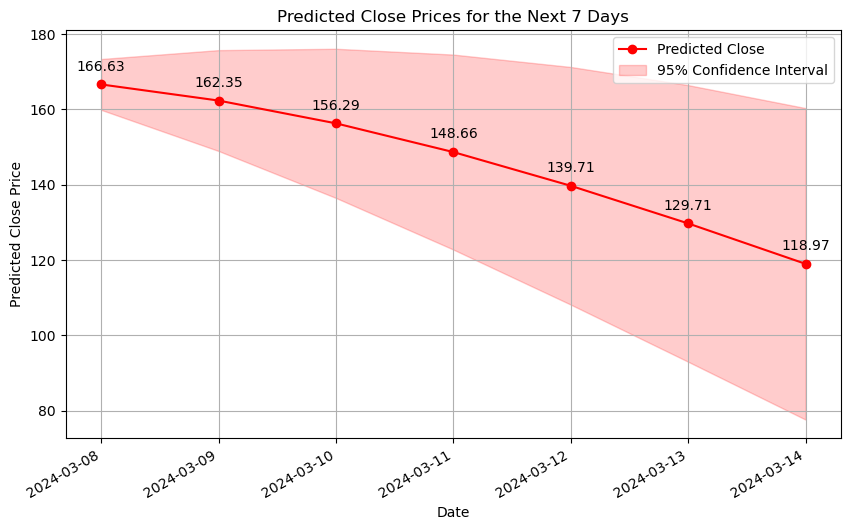

In [32]:
# Ensure date_range_next_7_days is a list of pandas datetime objects for plotting
date_range_next_7_days = pd.to_datetime(date_range_next_7_days)

plt.figure(figsize=(10, 6))

# Plotting the predicted Close prices for the next 7 days
plt.plot(date_range_next_7_days, y_pred_next_7_days, 'ro-', label='Predicted Close')

# Calculating and plotting the 95% confidence interval
lower_bound = y_pred_next_7_days - 1.96 * sigma_next_7_days
upper_bound = y_pred_next_7_days + 1.96 * sigma_next_7_days
plt.fill_between(date_range_next_7_days, lower_bound, upper_bound, color='red', alpha=0.2, label='95% Confidence Interval')

# Annotating each prediction with its value
for i, txt in enumerate(y_pred_next_7_days):
    plt.annotate(f"{txt:.2f}", (mdates.date2num(date_range_next_7_days[i]), y_pred_next_7_days[i]), textcoords="offset points", xytext=(0,10), ha='center')

# Formatting the plot
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gcf().autofmt_xdate() # Rotate date labels for better readability
plt.xlabel('Date')
plt.ylabel('Predicted Close Price')
plt.title('Predicted Close Prices for the Next 7 Days')
plt.legend()
plt.grid(True)
plt.show()